# MeanReversion backtest with Portfolio Optimization

In the chapter 04, we introduced `zipline` to simulate the computation of alpha factors from trailing cross-sectional market, fundamental, and alternative data. 

Now we will exploit the alpha factors to derive and act on buy and sell signals using the custom MeanReversion factor developed in the last chapter.

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import sys
from pytz import UTC
import logbook
%pip install logbook zipline-reloaded pyfolio-reloaded PyPortfolioOpt matplotlib seaborn --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from logbook import (NestedSetup, NullHandler, Logger, 
                     StreamHandler, StderrHandler, 
                     INFO, WARNING, DEBUG, ERROR)

from zipline import run_algorithm
from zipline.api import (attach_pipeline,
                         date_rules,
                         time_rules,
                         get_datetime,
                         order_target_percent,
                         pipeline_output,
                         record, schedule_function,
                         get_open_orders,
                         calendars,
                         set_commission, 
                         set_slippage)
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.factors import Returns, AverageDollarVolume

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, objective_functions
from pypfopt import expected_returns
from pypfopt.exceptions import OptimizationError

from pyfolio.utils import extract_rets_pos_txn_from_zipline


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\Alex\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
sns.set_style('whitegrid')

## Logging Setup

In [3]:
# setup stdout logging
format_string = '[{record.time: %H:%M:%S.%f}]: {record.level_name}: {record.message}'
zipline_logging = NestedSetup([NullHandler(level=DEBUG),
                               StreamHandler(sys.stdout, format_string=format_string, level=INFO),
                               StreamHandler(sys.stdout, format_string=format_string, level=WARNING),
                               StreamHandler(sys.stderr, level=ERROR)])
zipline_logging.push_application()
log = Logger('Algorithm')

## Algo Settings

In [4]:
# Settings
MONTH = 21
YEAR = 12 * MONTH
N_LONGS = 50
N_SHORTS = 50
MIN_POS = 5
VOL_SCREEN = 1000

In [20]:
start = pd.Timestamp('2013-01-01')
end = pd.Timestamp('2017-01-01')   
capital_base = 1e7

## Mean Reversion Factor

In [6]:
class MeanReversion(CustomFactor):
    """Compute ratio of latest monthly return to 12m average,
       normalized by std dev of monthly returns"""
    inputs = [Returns(window_length=MONTH)]
    window_length = YEAR

    def compute(self, today, assets, out, monthly_returns):
        df = pd.DataFrame(monthly_returns)
        factor = df.iloc[-1].sub(df.mean()).div(df.std())
        out[:] = factor

## Create Pipeline

The Pipeline created by the `compute_factors()` method returns a table with a long and a short column for the 25 stocks with the largest negative and positive deviations of their last monthly return from its annual average, normalized by the standard deviation. It also limited the universe to the 500 stocks with the highest average trading volume over the last 30 trading days. 

In [7]:
def compute_factors():
    """Create factor pipeline incl. mean reversion,
        filtered by 30d Dollar Volume; capture factor ranks"""
    mean_reversion = MeanReversion()
    dollar_volume = AverageDollarVolume(window_length=30)
    return Pipeline(columns={'longs'  : mean_reversion.bottom(N_LONGS),
                             'shorts' : mean_reversion.top(N_SHORTS),
                             'ranking': mean_reversion.rank(ascending=False)},
                    screen=dollar_volume.top(VOL_SCREEN))

`Before_trading_start()` ensures the daily execution of the pipeline and the recording of the results, including the current prices.

In [8]:
def before_trading_start(context, data):
    """Run factor pipeline"""
    context.factor_data = pipeline_output('factor_pipeline')
    record(factor_data=context.factor_data.ranking)
    assets = context.factor_data.index
    record(prices=data.current(assets, 'price'))

## Set up Rebalancing

The new `rebalance()` method submits trade orders to the `exec_trades()` method for the assets flagged for long and short positions by the pipeline with equal positive and negative weights. 

It also divests any current holdings that are no longer included in the factor signals:

In [9]:
def exec_trades(data, positions):
    """Place orders for assets using target portfolio percentage"""
    for asset, target_percent in positions.items():
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)

In [11]:
def rebalance(context, data):
    """Compute long, short and obsolete holdings; place orders"""

    factor_data = context.factor_data
    assets = factor_data.index

    longs = assets[factor_data.longs]
    shorts = assets[factor_data.shorts]
    
    divest = context.portfolio.positions.keys() - longs.union(shorts)
    exec_trades(data, positions={asset: 0 for asset in divest})
    log.info('{} | {:11,.0f}'.format(get_datetime().date(), 
                                   context.portfolio.portfolio_value))

    # get price history
    prices = data.history(assets, fields='price',
                          bar_count=252+1, # for 1 year of returns 
                          frequency='1d')
    
    # get optimal weights if sufficient candidates
    if len(longs) > MIN_POS and len(shorts) > MIN_POS:
        try:
            long_weights = optimize_weights(prices.loc[:, longs])
            short_weights = optimize_weights(prices.loc[:, shorts], short=True)
            
            exec_trades(data, positions=long_weights)
            exec_trades(data, positions=short_weights)
        except Exception as e:
            log.warn('{} {}'.format(get_datetime().date(), e))
    # exit remaining positions
    divest_pf = {asset: 0 for asset in context.portfolio.positions.keys()}
    exec_trades(data, positions=divest_pf)

## Optimize Portfolio Weights

In [ ]:
def optimize_weights(prices, short=False):

    returns = expected_returns.mean_historical_return(
        prices=prices, frequency=252) # get expected returns over annualized period
    cov = risk_models.sample_cov(prices=prices, frequency=252)
    # get covariance matrix between all the assets , annulized to 252 trading days 
    

    # get weights that maximize the Sharpe ratio
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(0, 1),
                           solver='SCS') # generate the efficient frontier which is a set of optimal portfolios that offer the highest expected return for a defined level of risk
    ef.max_sharpe() # get the portfolio that maximizes the Sharpe ratio
    if short:
        return {asset: -weight for asset, weight in ef.clean_weights().items()}
    else:
        return ef.clean_weights()

## Initialize Backtest

The `rebalance()` method runs according to `date_rules` and `time_rules` set by the `schedule_function()` utility at the beginning of the week, right after `market_open` as stipulated by the built-in `US_EQUITIES` calendar (see docs for details on rules). 

You can also specify a trade commission both in relative terms and as a minimum amount. There is also an option to define slippage, which is the cost of an adverse change in price between trade decision and execution

In [18]:
def initialize(context):
    """Setup: register pipeline, schedule rebalancing,
        and set trading params"""
    attach_pipeline(compute_factors(), 'factor_pipeline')
    schedule_function(rebalance,
                      date_rules.week_start(),
                      time_rules.market_open(),
                      calendar=calendars.US_EQUITIES)

    set_commission(us_equities=commission.PerShare(cost=0.00075, min_trade_cost=.01))
    set_slippage(us_equities=slippage.VolumeShareSlippage(volume_limit=0.0025, price_impact=0.01))

## Run Algorithm

The algorithm executes upon calling the `run_algorithm()` function and returns the backtest performance `DataFrame`.

In [21]:
backtest = run_algorithm(start=start,
                         end=end,
                         initialize=initialize,
                         before_trading_start=before_trading_start,
                         bundle='quandl',
                         capital_base=capital_base)

[ 02:28:33.502498]: INFO: 2013-01-07 |  10,000,000


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\empyrical\stats.py:799: RuntimeWarning: invalid value encountered in divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\empyrical\stats.py:710: RuntimeWarning: invalid value encountered in divide
  np.divide(
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\empyrical\stats.py:799: RuntimeWarning: invalid value encountered in divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\empyrical\stats.py:710: RuntimeWarning: invalid value encountered i

[ 02:28:36.973103]: INFO: 2013-01-14 |   9,923,239
[ 02:28:38.173101]: INFO: 2013-01-22 |   9,921,592


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


[ 02:28:39.292381]: INFO: 2013-01-28 |   9,974,489
[ 02:28:40.513570]: INFO: 2013-02-04 |  10,083,519
[ 02:28:41.825791]: INFO: 2013-02-11 |  10,099,932
[ 02:28:43.147177]: INFO: 2013-02-19 |   9,742,038
[ 02:28:44.522829]: INFO: 2013-02-25 |  10,035,381
[ 02:28:46.502711]: INFO: 2013-03-04 |  10,192,612
[ 02:28:48.066073]: INFO: 2013-03-11 |   9,643,435
[ 02:28:50.680528]: INFO: 2013-03-18 |   9,368,684
[ 02:28:52.503194]: INFO: 2013-03-25 |   9,154,923
[ 02:28:53.970231]: INFO: 2013-04-01 |   8,760,360
[ 02:28:55.664536]: INFO: 2013-04-08 |   8,874,783
[ 02:28:57.380280]: INFO: 2013-04-15 |   8,685,081
[ 02:28:59.180721]: INFO: 2013-04-22 |   8,341,509
[ 02:29:00.809827]: INFO: 2013-04-29 |   9,262,796
[ 02:29:02.568513]: INFO: 2013-05-06 |   8,454,797
[ 02:29:04.276562]: INFO: 2013-05-13 |   8,280,571
[ 02:29:07.027266]: INFO: 2013-05-20 |   8,087,101


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


[ 02:29:08.772373]: INFO: 2013-05-28 |   7,086,440
[ 02:29:10.473714]: INFO: 2013-06-03 |   7,294,193
[ 02:29:12.300379]: INFO: 2013-06-10 |   7,542,367
[ 02:29:14.218151]: INFO: 2013-06-17 |   7,876,464
[ 02:29:16.045925]: INFO: 2013-06-24 |   6,643,579
[ 02:29:17.954829]: INFO: 2013-07-01 |   6,178,412
[ 02:29:19.717902]: INFO: 2013-07-08 |   5,643,273
[ 02:29:22.782981]: INFO: 2013-07-15 |   6,163,555
[ 02:29:25.406894]: INFO: 2013-07-22 |   6,493,076
[ 02:29:27.416933]: INFO: 2013-07-29 |   6,290,186
[ 02:29:29.616659]: INFO: 2013-08-05 |   6,648,429
[ 02:29:31.877800]: INFO: 2013-08-12 |   7,128,945
[ 02:29:33.866343]: INFO: 2013-08-19 |   5,692,451
[ 02:29:35.943685]: INFO: 2013-08-26 |   6,544,182
[ 02:29:38.231949]: INFO: 2013-09-03 |   6,601,978
[ 02:29:40.054995]: INFO: 2013-09-09 |   7,569,990
[ 02:29:42.119108]: INFO: 2013-09-16 |   7,508,181
[ 02:29:45.011065]: INFO: 2013-09-23 |   7,954,231
[ 02:29:47.273867]: INFO: 2013-09-30 |   7,138,802
[ 02:29:49.309468]: INFO: 2013-

C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


[ 02:29:51.301849]: INFO: 2013-10-14 |   6,383,783
[ 02:29:53.219583]: INFO: 2013-10-21 |   7,199,358
[ 02:29:54.929330]: INFO: 2013-10-28 |   7,192,597
[ 02:29:56.683976]: INFO: 2013-11-04 |   7,492,006
[ 02:29:58.308262]: INFO: 2013-11-11 |   6,660,782
[ 02:30:00.040716]: INFO: 2013-11-18 |   7,113,813
[ 02:30:02.769264]: INFO: 2013-11-25 |   7,066,564
[ 02:30:04.403430]: INFO: 2013-12-02 |   7,417,611
[ 02:30:06.094668]: INFO: 2013-12-09 |   7,149,871
[ 02:30:08.069357]: INFO: 2013-12-16 |   6,821,674
[ 02:30:09.879334]: INFO: 2013-12-23 |   7,731,089
[ 02:30:11.614744]: INFO: 2013-12-30 |   7,739,262


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


[ 02:30:13.253721]: INFO: 2014-01-06 |   7,656,206
[ 02:30:14.838633]: INFO: 2014-01-13 |   7,385,547
[ 02:30:17.236085]: INFO: 2014-01-21 |   6,996,587
[ 02:30:19.137551]: INFO: 2014-01-27 |   6,785,427
[ 02:30:20.591919]: INFO: 2014-02-03 |   6,875,523
[ 02:30:22.165211]: INFO: 2014-02-10 |   7,319,919
[ 02:30:23.830571]: INFO: 2014-02-18 |   8,222,936
[ 02:30:25.128791]: INFO: 2014-02-24 |   8,008,359
[ 02:30:26.428858]: INFO: 2014-03-03 |   9,117,644
[ 02:30:27.664216]: INFO: 2014-03-10 |   9,195,696
[ 02:30:28.833803]: INFO: 2014-03-17 |   9,137,119
[ 02:30:30.168389]: INFO: 2014-03-24 |   8,728,092
[ 02:30:31.970143]: INFO: 2014-03-31 |   8,779,692
[ 02:30:33.371854]: INFO: 2014-04-07 |   8,040,492
[ 02:30:34.896470]: INFO: 2014-04-14 |   7,442,968
[ 02:30:36.253803]: INFO: 2014-04-21 |   8,038,358
[ 02:30:37.833181]: INFO: 2014-04-28 |   7,890,890
[ 02:30:39.259590]: INFO: 2014-05-05 |   8,296,623
[ 02:30:40.602329]: INFO: 2014-05-12 |   8,508,459
[ 02:30:41.999222]: INFO: 2014-

C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


[ 02:30:50.302211]: INFO: 2014-06-30 |   8,261,256
[ 02:30:51.869928]: INFO: 2014-07-07 |   8,484,815


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


[ 02:30:53.673474]: INFO: 2014-07-14 |   8,386,330
[ 02:30:56.275564]: INFO: 2014-07-21 |   8,780,962
[ 02:30:57.658287]: INFO: 2014-07-28 |   8,616,458
[ 02:30:59.464793]: INFO: 2014-08-04 |   8,656,239
[ 02:31:00.765412]: INFO: 2014-08-11 |   9,207,032
[ 02:31:01.898627]: INFO: 2014-08-18 |   9,736,395
[ 02:31:03.013597]: INFO: 2014-08-25 |   9,788,385
[ 02:31:04.125402]: INFO: 2014-09-02 |   9,862,384
[ 02:31:05.180956]: INFO: 2014-09-08 |   9,391,765
[ 02:31:06.485332]: INFO: 2014-09-15 |   9,713,441
[ 02:31:07.871406]: INFO: 2014-09-22 |   9,651,281
[ 02:31:09.139089]: INFO: 2014-09-29 |   8,351,285
[ 02:31:11.178393]: INFO: 2014-10-06 |   6,518,452
[ 02:31:12.575526]: INFO: 2014-10-13 |   4,645,328
[ 02:31:13.889336]: INFO: 2014-10-20 |   5,855,048
[ 02:31:15.192171]: INFO: 2014-10-27 |   6,607,156
[ 02:31:16.387576]: INFO: 2014-11-03 |   7,885,004
[ 02:31:17.626822]: INFO: 2014-11-10 |   7,821,868
[ 02:31:18.844704]: INFO: 2014-11-17 |   8,245,038
[ 02:31:19.955636]: INFO: 2014-

C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


[ 02:32:12.125785]: INFO: 2015-10-05 |   7,936,460
[ 02:32:13.288404]: INFO: 2015-10-12 |   8,638,261
[ 02:32:14.910146]: INFO: 2015-10-19 |   8,681,499
[ 02:32:16.008178]: INFO: 2015-10-26 |   9,053,584
[ 02:32:17.157015]: INFO: 2015-11-02 |  10,198,272
[ 02:32:18.458488]: INFO: 2015-11-09 |   9,572,710
[ 02:32:19.635094]: INFO: 2015-11-16 |   9,184,927
[ 02:32:20.871615]: INFO: 2015-11-23 |  10,113,372
[ 02:32:22.009230]: INFO: 2015-11-30 |  10,576,233
[ 02:32:23.302604]: INFO: 2015-12-07 |  10,003,003
[ 02:32:24.540421]: INFO: 2015-12-14 |   9,615,041
[ 02:32:26.351413]: INFO: 2015-12-21 |  10,114,206
[ 02:32:27.401046]: INFO: 2015-12-28 |  10,053,500
[ 02:32:28.491589]: INFO: 2016-01-04 |   9,733,740
[ 02:32:29.778049]: INFO: 2016-01-11 |   8,741,538
[ 02:32:30.995450]: INFO: 2016-01-19 |   8,667,767


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


[ 02:32:32.989152]: INFO: 2016-01-25 |   8,327,373
[ 02:32:34.244085]: INFO: 2016-02-01 |   8,383,799
[ 02:32:35.469644]: INFO: 2016-02-08 |   4,921,725
[ 02:32:36.741576]: INFO: 2016-02-16 |   6,025,694
[ 02:32:38.314017]: INFO: 2016-02-22 |   8,490,536
[ 02:32:39.490136]: INFO: 2016-02-29 |   7,773,733
[ 02:32:40.781783]: INFO: 2016-03-07 |   9,015,821
[ 02:32:41.988157]: INFO: 2016-03-14 |  10,668,952
[ 02:32:43.210395]: INFO: 2016-03-21 |  11,175,636
[ 02:32:44.239441]: INFO: 2016-03-28 |  11,162,730
[ 02:32:45.501946]: INFO: 2016-04-04 |  11,554,889
[ 02:32:46.630816]: INFO: 2016-04-11 |  11,905,463
[ 02:32:47.848796]: INFO: 2016-04-18 |  12,384,842
[ 02:32:49.569481]: INFO: 2016-04-25 |  12,467,780
[ 02:32:50.866863]: INFO: 2016-05-02 |  13,053,684
[ 02:32:52.365301]: INFO: 2016-05-09 |  14,051,827
[ 02:32:53.797802]: INFO: 2016-05-16 |  12,404,062
[ 02:32:55.192028]: INFO: 2016-05-23 |   9,985,135
[ 02:32:55.731638]: WARNING: 2016-05-23 at least one of the assets must have an ex

C:\Users\Alex\AppData\Local\Temp\tmp2_r4s0fi\ipykernel_143332\1834229224.py:29: DeprecationWarning: Use warning instead
  log.warn('{} {}'.format(get_datetime().date(), e))


[ 02:32:56.572513]: INFO: 2016-05-31 |  10,939,002
[ 02:32:57.744207]: INFO: 2016-06-06 |  11,356,736
[ 02:32:59.139203]: INFO: 2016-06-13 |  11,142,244
[ 02:33:00.503343]: INFO: 2016-06-20 |  11,379,502
[ 02:33:02.395567]: INFO: 2016-06-27 |  10,184,349


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


[ 02:33:03.599845]: INFO: 2016-07-05 |  10,457,857
[ 02:33:04.629481]: INFO: 2016-07-11 |  10,948,309
[ 02:33:05.826181]: INFO: 2016-07-18 |  11,048,753
[ 02:33:08.765387]: INFO: 2016-07-25 |  10,831,686
[ 02:33:09.937458]: INFO: 2016-08-01 |  11,899,741
[ 02:33:11.141377]: INFO: 2016-08-08 |  11,284,396
[ 02:33:12.364718]: INFO: 2016-08-15 |  10,794,248
[ 02:33:13.570719]: INFO: 2016-08-22 |  10,338,312
[ 02:33:15.195417]: INFO: 2016-08-29 |  10,454,133
[ 02:33:16.428203]: INFO: 2016-09-06 |  10,458,672
[ 02:33:17.438539]: INFO: 2016-09-12 |  10,675,730


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


[ 02:33:18.822607]: INFO: 2016-09-19 |  10,449,870
[ 02:33:20.236410]: INFO: 2016-09-26 |  11,035,755
[ 02:33:21.419112]: INFO: 2016-10-03 |  10,503,430
[ 02:33:22.681591]: INFO: 2016-10-10 |   9,541,431
[ 02:33:23.830309]: INFO: 2016-10-17 |   9,144,729
[ 02:33:25.181267]: INFO: 2016-10-24 |   9,240,122
[ 02:33:27.048512]: INFO: 2016-10-31 |  10,021,031
[ 02:33:28.349653]: INFO: 2016-11-07 |  10,598,003
[ 02:33:29.664507]: INFO: 2016-11-14 |   9,863,148
[ 02:33:31.012060]: INFO: 2016-11-21 |   7,494,703
[ 02:33:32.010061]: INFO: 2016-11-28 |   8,479,386
[ 02:33:33.122786]: INFO: 2016-12-05 |   7,058,988
[ 02:33:34.386199]: INFO: 2016-12-12 |   6,868,112
[ 02:33:35.410147]: INFO: 2016-12-19 |   4,817,430


C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


[ 02:33:36.518801]: INFO: 2016-12-27 |   3,959,806


## Extract pyfolio Inputs

The `extract_rets_pos_txn_from_zipline` utility provided by `pyfolio` extracts the data used to compute performance metrics.

In [22]:
returns, positions, transactions = extract_rets_pos_txn_from_zipline(backtest)

## Persist Results for use with `pyfolio`

In [23]:
with pd.HDFStore('backtests.h5') as store:
    store.put('returns/pf_opt', returns)
    store.put('transactions/pf_opt', transactions)

C:\Users\Alex\AppData\Local\Temp\tmp2_r4s0fi\ipykernel_143332\2311439529.py:3: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['sid', 'symbol', 'order_id', 'commission'], dtype='object')]

  store.put('transactions/pf_opt', transactions)


In [24]:
with pd.HDFStore('backtests.h5') as store:
    returns_pf = store['returns/pf_opt']
    tx_pf = store['transactions/pf_opt']
    returns_ew = store['returns/equal_weight']
    tx_ew = store['transactions/equal_weight']

## Plot Results

NameError: name 'returns' is not defined

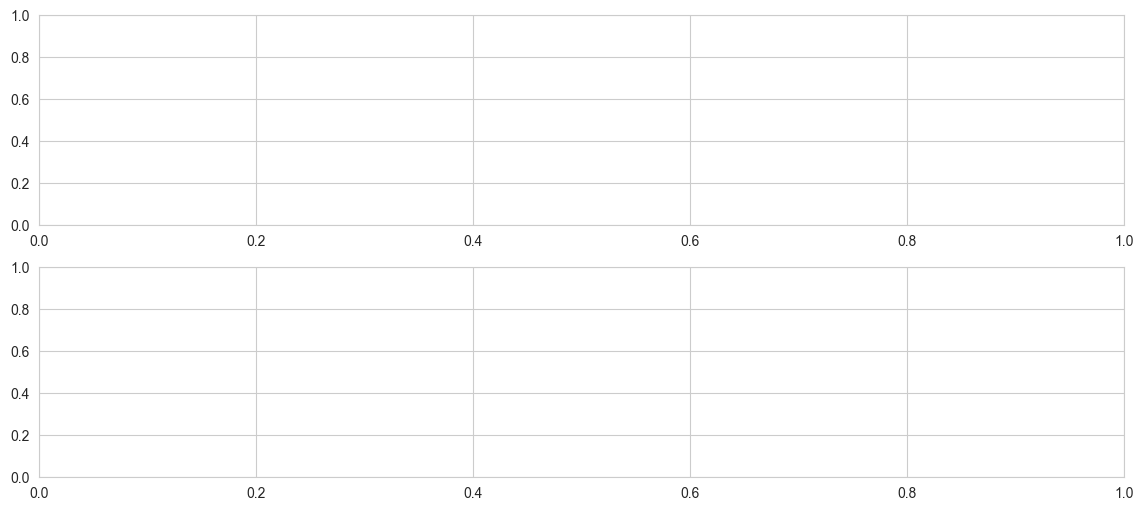

In [16]:
fig, axes= plt.subplots(nrows=2, figsize=(14,6))
returns.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Returns')
transactions.groupby(transactions.dt.dt.day).txn_dollars.sum().cumsum().plot(ax=axes[1], title='Cumulative Transactions')
sns.despine()
fig.tight_layout();

NameError: name 'returns_ew' is not defined

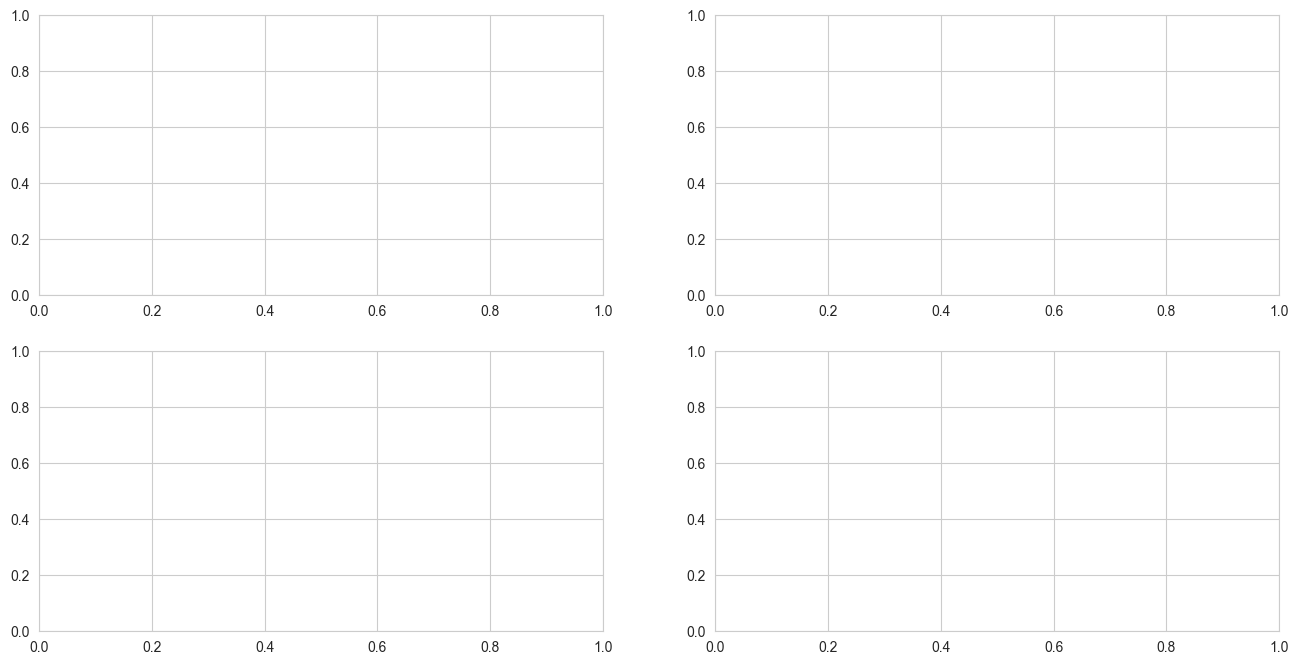

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), sharey='col')
returns_ew.add(1).cumprod().sub(1).plot(ax=axes[0][0],
                                        title='Cumulative Returns - Equal Weight')
returns_pf.add(1).cumprod().sub(1).plot(ax=axes[1][0],
                                        title='Cumulative Returns - Mean-Variance Optimization')
tx_ew.groupby(tx_ew.dt.dt.day).txn_dollars.sum().cumsum().plot(ax=axes[0][1],
                                                               title='Cumulative Transactions - Equal Weight')
tx_pf.groupby(tx_pf.dt.dt.day).txn_dollars.sum().cumsum().plot(ax=axes[1][1],
                                                               title='Cumulative Transactions - Mean-Variance Optimization')
fig.suptitle('Equal Weight vs Mean-Variance Optimization', fontsize=16)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)